In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 📦 STEP 1: Load and Clean Raw Data

In [18]:
# Load the CSV file
df = pd.read_csv("Year Order Item Data.csv")

# Drop columns that are irrelevant for customer KPI analysis
df.drop(columns=[
    'discount', 'total_tax', 'sap_code', 'delivery_charge', 'container_charge',
    'service_charge', 'additional_charge', 'waived_off', 'round_off',
    'customer_address', 'persons', 'order_cancel_reason', 'payment_type',
    'order_type', 'status', 'area', 'virtual_brand_name',
    'brand_grouping', 'assign_to'
], inplace=True)

# Convert 'date' column to datetime format for further time-based analysis
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

# Filter out incomplete or failed orders — keep only valid sales
df = df[df['total'] != 0].copy()

# 📞 STEP 2: Focus on Known Customers

In [19]:
# Only analyze orders with known customer phone numbers
df_known = df[df['customer_phone'].notnull()].copy()
df_known['customer_phone'] = df_known['customer_phone'].astype(str)

# Extract helpful time fields for grouping and trends
df_known['day'] = df_known['date'].dt.day_name()
df_known['month-year'] = df_known['date'].dt.strftime('%Y-%b')
df_known['month'] = df_known['date'].dt.to_period('M')
df_known['date_only'] = df_known['date'].dt.date
df_known['date_dt'] = pd.to_datetime(df_known['date_only'])

# 📊 STEP 3: Exploratory Visit Stats

In [20]:
# Total visits per day of week
day_wise_visits = (
    df_known.groupby('day')
    .size().reset_index(name='Visits by Day')
    .sort_values(by='Visits by Day', ascending=False)
)

# Total visits per month
monthly_visits = (
    df_known.groupby('month-year')
    .size().reset_index(name='Visits by Month')
    .sort_values(by='Visits by Month', ascending=False)
)

# 💰 STEP 4: Customer-Level KPI Construction

In [21]:
# 1. Total spend (Customer Lifetime Value)
clv = df_known.groupby('customer_phone')['total'].sum().reset_index(name='CLV')

# 2. Calculate true AOV by grouping on invoice
invoice_totals = df_known.groupby(['customer_phone', 'invoice_no'])['total'].sum().reset_index()
aov = invoice_totals.groupby('customer_phone')['total'].mean().reset_index(name='AOV')

# 3. Average spend per item (less important but kept)
avg_spend = df_known.groupby('customer_phone')['total'].mean().reset_index(name='Avg Spend per Visit')

# 4. Visit count = unique invoices
visit_count = df_known.groupby('customer_phone')['invoice_no'].nunique().reset_index(name='Frequency')

# 5. Recency = days since last order
latest_date = df_known['date'].max()
recency = df_known.groupby('customer_phone')['date'].max().reset_index()
recency['Recency'] = (latest_date - recency['date']).dt.days

# 6. Tenure = days since first order
first_order = df_known.groupby('customer_phone')['date_dt'].min().reset_index(name='First_Order')
first_order['Tenure'] = (latest_date - first_order['First_Order']).dt.days

# 7. Product variety per customer
diversity = df_known.groupby('customer_phone')['item_name'].nunique().reset_index(name='Unique_Items_Ordered')


# 🧮 STEP 5: RFM Analysis + Clustering

In [23]:
# Combine metrics into RFM model
rfm = recency[['customer_phone', 'Recency']]\
    .merge(visit_count, on='customer_phone')\
    .merge(clv.rename(columns={'CLV': 'Monetary'}), on='customer_phone')

# Create binned RFM scores
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

rfm['RFM_Score'] = rfm[['R_score', 'F_score', 'M_score']].astype(int).sum(axis=1)

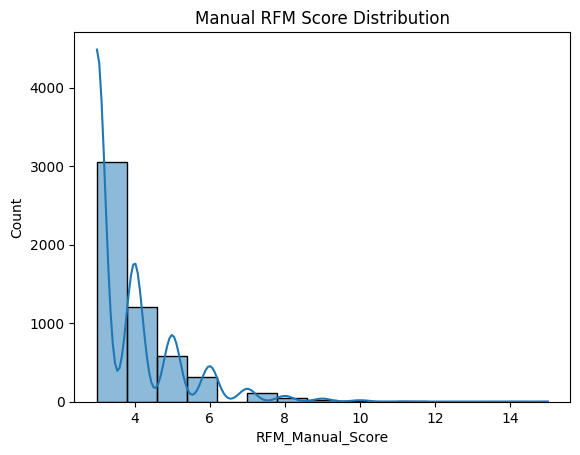

,customer_phone,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Manual_Score
0,20.0,185,1,220,1,1,1,6,3
1,3341804938.0,227,1,2124,1,1,3,8,5
2,3548700950.0,122,1,650,1,1,2,9,4
3,4038617090.0,84,1,175,1,1,1,7,3
4,4446314112.0,121,1,1572,1,1,3,10,5


In [24]:
# Manual scoring via rules
def r_score(x): return 5 if x <= 7 else 4 if x <= 14 else 3 if x <= 30 else 2 if x <= 60 else 1
def f_score(x): return 5 if x >= 20 else 4 if x >= 10 else 3 if x >= 5 else 2 if x >= 2 else 1
def m_score(x): return 5 if x >= 10000 else 4 if x >= 5000 else 3 if x >= 1000 else 2 if x >= 500 else 1

rfm_manual = rfm.copy()
rfm_manual['R_score'] = rfm_manual['Recency'].apply(r_score)
rfm_manual['F_score'] = rfm_manual['Frequency'].apply(f_score)
rfm_manual['M_score'] = rfm_manual['Monetary'].apply(m_score)
rfm_manual['RFM_Manual_Score'] = rfm_manual[['R_score', 'F_score', 'M_score']].sum(axis=1)

sns.histplot(rfm_manual['RFM_Manual_Score'], bins=15, kde=True)
plt.title("Manual RFM Score Distribution")
plt.show()
rfm_manual.head()

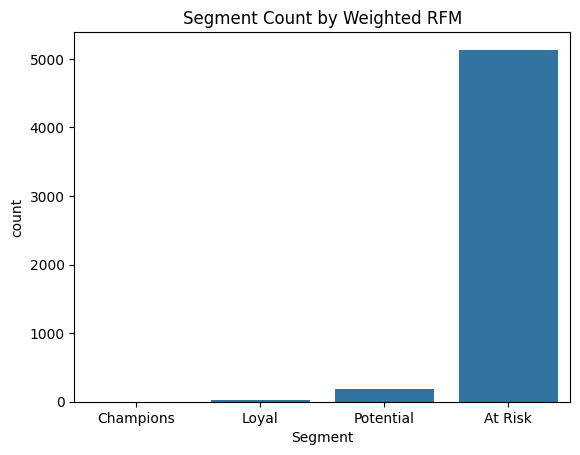

,customer_phone,RFM_Weighted,Segment
0,20.0,1.0,At Risk
1,3341804938.0,1.4,At Risk
2,3548700950.0,1.2,At Risk
3,4038617090.0,1.0,At Risk
4,4446314112.0,1.4,At Risk


In [25]:
# Weighted sum with Recency > Frequency > Monetary
rfm_weighted = rfm_manual.copy()
rfm_weighted['RFM_Weighted'] = (0.5 * rfm_weighted['R_score'] +
                                0.3 * rfm_weighted['F_score'] +
                                0.2 * rfm_weighted['M_score']).round(2)

def rfm_segment(score):
    return 'Champions' if score >= 4.5 else 'Loyal' if score >= 3.5 else 'Potential' if score >= 2.5 else 'At Risk'

rfm_weighted['Segment'] = rfm_weighted['RFM_Weighted'].apply(rfm_segment)

sns.countplot(data=rfm_weighted, x='Segment', order=['Champions', 'Loyal', 'Potential', 'At Risk'])
plt.title("Segment Count by Weighted RFM")
plt.show()
rfm_weighted[['customer_phone', 'RFM_Weighted', 'Segment']].head()


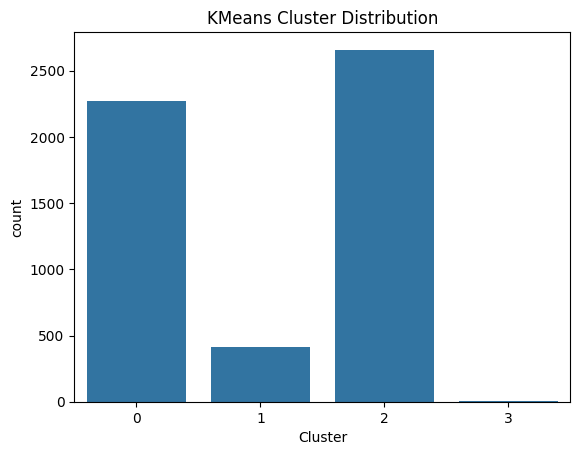

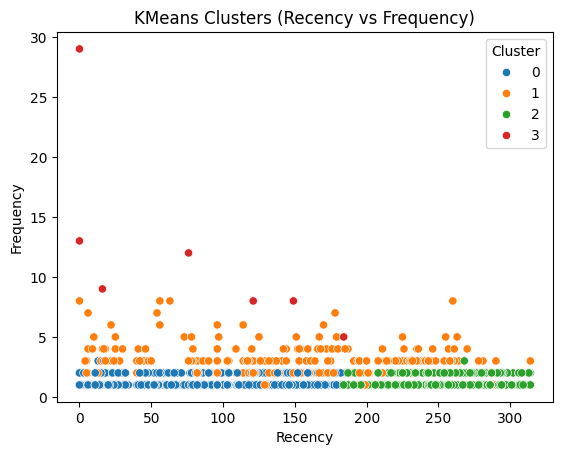

In [26]:
# Standardize numeric fields for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Optional: visualize clusters
sns.countplot(data=rfm, x='Cluster')
plt.title("KMeans Cluster Distribution")
plt.show()

sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters (Recency vs Frequency)")
plt.show()


# 🧾 STEP 6: Final Customer KPI Table

In [27]:
# Build the final KPI master sheet
kpi_master = clv.merge(aov, on='customer_phone')\
                .merge(avg_spend, on='customer_phone')\
                .merge(visit_count, on='customer_phone')\
                .merge(recency[['customer_phone', 'Recency']], on='customer_phone')\
                .merge(first_order[['customer_phone', 'Tenure']], on='customer_phone')\
                .merge(diversity, on='customer_phone')\
                .merge(rfm[['customer_phone', 'Cluster']], on='customer_phone')

# Optional: Attach most frequent name per phone for personalization
name_map = (
    df_known.groupby('customer_phone')['customer_name']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Valued Customer')
    .reset_index()
)
kpi_master = kpi_master.merge(name_map, on='customer_phone', how='left')

In [28]:
# Save the customer-level KPI sheet
kpi_master.to_csv("../results/customer_analysis/Customer_KPIs_KnownPhonesOnly.csv", index=False)